## 3.5. 성능 향상을 위한 방법

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sub_dir = "C:/dacon/ch03/submission/"
os.chdir(sub_dir)

### 3.5.1. 앙상블

<font color='blue'>5개의 submission 파일명을 각각 '모델 번호_사용한 모델=임시 스코어.csv' 형식으로 변경한 뒤 다음 과정을 진행합니다. <br/>예를 들어, 'model1_lgbm.csv' 파일의 임시 스코어가 2.29라면 'model1_lgbm=2.29.csv' 형식으로 변경하는 것입니다.

In [3]:
sub_list = [] # 작업 경로 안에 있는 파일 중 확장자가 .csv인 파일을 담을 리스트 생성
fname_list = [] # 확장자를 제외한 파일명을 담을 리스트 생성

for filename in os.listdir(): # 작업 경로 안에 있는 모든 파일의 리스트 불러오기
    fname, ext = os.path.splitext(filename) # filename을 파일명과 확장자로 분리
    if ext == '.csv': # 확장자가 .csv인 파일인 경우
        sub_list.append(filename) # filename을 sub_list에 추가
        fname_list.append(fname) # 파일명을 fname_list에 추가

#### 3.5.1.1. 결괏값 간 상관계수 확인

In [4]:
# 상관계수 행렬을 저장할 데이터프레임 생성
corr_df = pd.DataFrame()

for file in sub_list:
    # 각 submission 파일의 18~20_ride 변수를 sub_df에 저장
    sub_df = pd.read_csv(file, engine = 'python').iloc[:,1:]
    # 변수명을 파일의 이름으로 지정
    sub_df.columns = [str(file)]
    # sub_df를 corr_df에 병합
    corr_df = pd.concat([corr_df, sub_df], axis = 1)

# 상관계수 행렬 출력    
corr_df.corr()

,model1_lgbm=2.29.csv,model2_rf=2.34.csv,model3_rf=2.38.csv,model4_rf=2.36.csv,model5_rf=2.31.csv
model1_lgbm=2.29.csv,1.000000,0.977246,0.972529,0.973676,0.981939
model2_rf=2.34.csv,0.977246,1.000000,0.995776,0.992885,0.990955
model3_rf=2.38.csv,0.972529,0.995776,1.000000,0.995266,0.986214
model4_rf=2.36.csv,0.973676,0.992885,0.995266,1.000000,0.983549
model5_rf=2.31.csv,0.981939,0.990955,0.986214,0.983549,1.000000


In [5]:
corr_list = np.array(corr_df.corr().mean(axis = 0))  

model_list = [] # 모델명을 담을 리스트 생성
public_rmse_list = [] # 각 submission 파일의 임시 스코어를 담을 리스트 생성

for fname in fname_list:
    model = fname.split('=')[0] # '=' 기호를 기준으로 모델명을 분리
    model_list.append(model) # 모델명을 model_list에 추가

    score = fname.split('=')[-1] # '=' 기호를 기준으로 임시 스코어를 분리
    score = float(score) # 실수형으로 변환
    public_rmse_list.append(score) # 임시 스코어를 public_rmse_list에 추가
    
# model_list, public_rmse_list, corr_list를 변수로 하는 데이터프레임 생성
score_df = pd.DataFrame({'model': model_list, 'public_rmse': public_rmse_list,
                         'cor': corr_list})
score_df

,model,public_rmse,cor
0,model1_lgbm,2.29,0.981078
1,model2_rf,2.34,0.991372
2,model3_rf,2.38,0.989957
3,model4_rf,2.36,0.989075
4,model5_rf,2.31,0.988531


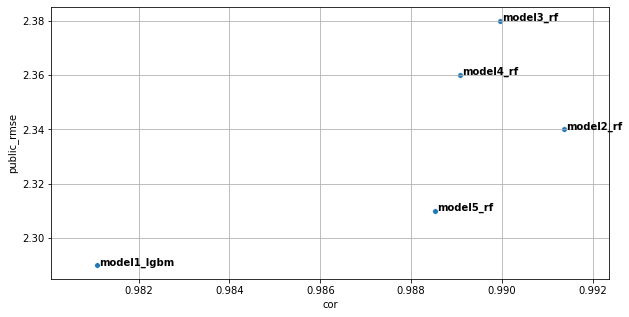

In [6]:
plt.figure(figsize=(10,5))
# 점의 사이즈가 30인 산점도 그래프
graph = sns.scatterplot(x="cor", y="public_rmse", data=score_df, s=30)
# 각 점에 대한 모델명 표시
for idx in range(0, score_df.shape[0]):
    graph.text(score_df.cor[idx]+0.00005 , score_df.public_rmse[idx]-0.00003, 
               score_df.model[idx], horizontalalignment='left', 
               size='medium', color='black', weight='semibold')

# x축 범위 지정
plt.xlim((score_df.cor.min()-0.001, score_df.cor.max()+0.001))
# y축 범위 지정
plt.ylim((score_df.public_rmse.min()-0.005, score_df.public_rmse.max()+0.005))
plt.grid() # 격자 무늬
plt.show()

#### 3.5.1.2. 여러 가지 앙상블 기법

In [7]:
ensemble_dir = "C:/dacon/ch03/submission/Ensemble1/"

# Ensemble1 폴더가 없다면 Ensemble1 폴더를 생성
if not os.path.isdir(ensemble_dir):
    os.mkdir(ensemble_dir)

# Ensemble1 폴더로 파일 이동
import shutil
shutil.move(sub_dir + 'model1_lgbm=2.29.csv', ensemble_dir + 'model1_lgbm=2.29.csv')
shutil.move(sub_dir + 'model5_rf=2.31.csv', ensemble_dir + 'model5_rf=2.31.csv')

# model1_lgbm=2.29.csv, model5_rf=2.31.csv 멱 평균
nf = 0
for f in os.listdir(ensemble_dir):
    ext = os.path.splitext(f)[-1] # 'Ensemble1' 폴더에 있는 파일의 확장자를 분리

    if ext == '.csv':
        sub = pd.read_csv(ensemble_dir + f) # 확장자명이 .csv라면 해당 데이터를 로드
    else:
        continue # 확장자명이 .csv가 아니라면 for문을 종료

    if len(sub.columns) !=2:
        continue # 로드한 데이터의 변수의 수가 2개가 아니라면 for문을 종료

    # 파일의 확장자명이 .csv이고, 변수의 수가 2개인 경우에만 밑의 조건문이 실행됩니다.
    if nf == 0:
        sub_df = sub # nf가 0이면 해당 데이터(sub)를 sub_df 에 저장
    else:
        sub_df = pd.merge(sub_df, sub, on="id") # nf가 0이 아니면 해당 데이터를 sub_df와 병합
    
    nf += 1

p = 21 # 하이퍼파라미터이므로 최적의 값을 찾아야 합니다.

# 파일의 개수(nf)가 2개 이상인 경우에만 밑의 조건문이 실행됩니다.
if nf >= 2: 
    pred = 0
    
    # 앞서 소개한 멱 평균의 식을 나타낸 코드입니다.
    for j in range(nf):
        pred = pred + sub_df.iloc[:,j+1]**p
    pred = pred / nf    
    pred = pred**(1/p)
    
    # 멱 평균 결과를 대입하여 데이터프레임 submit을 생성하고, csv파일로 저장 
    submit = pd.DataFrame({'id': sub_df.id, '18~20_ride': pred})
    fname = "ensemble_model1+model5.csv"
    submit.to_csv(fname, index=False)
    
    print(fname + '가 저장되었습니다!')

ensemble_model1+model5.csv가 저장되었습니다!


In [8]:
ensemble_dir = "C:/dacon/ch03/submission/Ensemble2/"

# Ensemble2 폴더가 없다면 Ensemble2 폴더를 생성
if not os.path.isdir(ensemble_dir):
    os.mkdir(ensemble_dir)

# Ensemble2 폴더로 파일 이동
import shutil
shutil.move(sub_dir + 'model2_rf=2.34.csv', ensemble_dir + 'model2_rf=2.34.csv')
shutil.move(sub_dir + 'model4_rf=2.36.csv', ensemble_dir + 'model4_rf=2.36.csv')

# model2_rf=2.34.csv, model4_rf=2.36.csv 멱 평균
nf = 0
for f in os.listdir(ensemble_dir):
    # 'Ensemble2' 폴더에 있는 파일의 확장자를 분리
    ext = os.path.splitext(f)[-1] 

    if ext == '.csv': 
        # 확장자명이 .csv라면 해당 데이터를 로드
        sub = pd.read_csv(ensemble_dir + f) 
    else: 
        # 확장자명이 .csv가 아니라면 for문을 종료
        continue 

    if len(sub.columns) !=2:
        # 로드한 데이터의 변수의 수가 2개가 아니라면 for 문을 종료
        continue 

    # 파일의 확장자명이 .csv이고, 변수의 수가 2개인 경우에만
    # 밑의 조건문이 실행됩니다.
    if nf == 0:
        sub_df = sub # nf가 0이면 해당 데이터(sub)를 sub_df 에 저장
    else: 
        # nf가 0이 아니면 해당 데이터를 sub_df와 병합
        sub_df = pd.merge(sub_df, sub, on="id") 
    
    nf += 1

p = 21 # 하이퍼파라미터이므로 최적의 값을 찾아야 합니다.

# 파일의 개수(nf)가 2개 이상인 경우에만 밑의 조건문이 실행됩니다.
if nf >= 2: 
    pred = 0
    
    # 앞서 소개한 멱 평균의 식을 나타낸 코드입니다.
    for j in range(nf):
        pred = pred + sub_df.iloc[:,j+1]**p
    pred = pred / nf    
    pred = pred**(1/p)

    # 멱 평균 결과를 대입하여 데이터프레임 submit을 생성하고, csv 파일로 저장
    submit = pd.DataFrame({'id': sub_df.id, '18~20_ride': pred})
    fname = "ensemble_model2+model4.csv"
    submit.to_csv(fname, index=False)
    
    print(fname + '가 저장되었습니다!')

ensemble_model2+model4.csv가 저장되었습니다!


In [9]:
# 앙상블 파일 로드
first = pd.read_csv('ensemble_model1+model5.csv')
second = pd.read_csv('ensemble_model2+model4.csv')
third = pd.read_csv('model3_rf=2.38.csv')

# 가중산술평균
w_mean = 0.22*first['18~20_ride'] + 0.30*second['18~20_ride'] + 0.48*third['18~20_ride']

# 최종 submission 파일 생성
sub['18~20_ride'] = w_mean
sub.to_csv('final_submission.csv', index=False)